In [1]:
import os
import numpy as np
from tsai.all import *
import sklearn.metrics as skm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

In [2]:
def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
    torch.use_deterministic_algorithms(True, warn_only=True)

In [3]:
set_seed(1337)

In [4]:
num_epochs = 100
few_shot_patience = 5

In [5]:
df = pd.read_pickle('togzhan_data_labeled.pkl').reset_index(drop=True)
df['Trial ID'] = df['Person No'].astype(str) + '_' + df['Trial No'].astype(str)

In [6]:
doctors_df = pd.read_pickle('doctors_data_labeled.pkl').reset_index(drop=True)
doctors_df['Trial ID'] = doctors_df['Person No'].astype(str) + '_' + doctors_df['Trial No'].astype(str)


In [7]:
for data in [df, doctors_df]:
    data['Lump'] = data['Type'].apply(lambda x: 1 if x < 9 else 0)
    data['Size'] = data['Type'].apply(lambda x: 0 if x in [0, 1, 2] else 1 if x in [3, 4, 5] else 2 if x in [6, 7, 8] else 3)
    data['Position'] = data['Type'].apply(lambda x: 0 if x in [0, 3, 6] else 1 if x in [1, 4, 7] else 2 if x in [2, 5, 8] else 3)


In [8]:
def split_trials(data, train_lump_count, val_lump_count, test_lump_count, train_no_lump_count, val_no_lump_count, test_no_lump_count):
    train_trials = []
    val_trials = []
    test_trials = []

    for person_no in data['Person No'].unique():
        person_df = data[data['Person No'] == person_no]

        for lump_type in range(9):  # 9 types with lump
            lump_df = person_df[person_df['Type'] == lump_type]
            lump_train, lump_temp = train_test_split(lump_df, test_size=(val_lump_count + test_lump_count), random_state=1337)
            lump_val, lump_test = train_test_split(lump_temp, test_size=test_lump_count, random_state=1337)
            
            train_trials.extend(lump_train.index.tolist())
            val_trials.extend(lump_val.index.tolist())
            test_trials.extend(lump_test.index.tolist())

        for no_lump_type in range(9, 13):  # 4 types without lump
            no_lump_df = person_df[person_df['Type'] == no_lump_type]
            no_lump_train, no_lump_temp = train_test_split(no_lump_df, test_size=(val_no_lump_count + test_no_lump_count), random_state=1337)
            no_lump_val, no_lump_test = train_test_split(no_lump_temp, test_size=test_no_lump_count, random_state=1337)
            
            train_trials.extend(no_lump_train.index.tolist())
            val_trials.extend(no_lump_val.index.tolist())
            test_trials.extend(no_lump_test.index.tolist())

    # Ensure there is no overlap between train, validation, and test sets
    train_trials = set(train_trials)
    val_trials = set(val_trials)
    test_trials = set(test_trials)

    assert len(train_trials & val_trials) == 0, "Train and Validation sets overlap!"
    assert len(train_trials & test_trials) == 0, "Train and Test sets overlap!"
    assert len(val_trials & test_trials) == 0, "Validation and Test sets overlap!"

    return train_trials, val_trials, test_trials

In [9]:
train_lump_count = 20
val_lump_count = 8
test_lump_count = 4

train_no_lump_count = 48
val_no_lump_count = 18
test_no_lump_count = 9

In [10]:
train_trials, val_trials, test_trials = split_trials(
    df,
    train_lump_count=train_lump_count,
    val_lump_count=val_lump_count,
    test_lump_count=test_lump_count,
    train_no_lump_count=train_no_lump_count,
    val_no_lump_count=val_no_lump_count,
    test_no_lump_count=test_no_lump_count
)

# Create masks for train, validation, and test sets
train_mask = df.index.isin(train_trials)
val_mask = df.index.isin(val_trials)
test_mask = df.index.isin(test_trials)

train_df = df[train_mask]
valid_df = df[val_mask]
test_df = df[test_mask]

# Verify the sizes of the resulting sets
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 3600
Validation set size: 1440
Test set size: 720


In [11]:
train_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
1,0,0,1,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...]",1,0_1,1,0,0
2,0,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...]",1,0_2,1,0,0
6,0,0,6,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 3.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 7.0, 7.0, 7.0, 6.0, 6.0, 8.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 6.0, 6.0, 6.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_6,1,0,0
7,0,0,7,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_7,1,0,0
8,0,0,8,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, ...]",1,0_8,1,0,0
...,...,...,...,...,...,...,...,...,...
5755,9,12,67,"[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 5.0, 5.0, 4.0, 4.0, 6.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 11.0, 12.0, 12.0, 10.0, 10.0, 8.0, 8.0, 8.0, 8.0, 7.0, 7.0, 6.0, 6.0, 6.0, 6.0, 6.0, 4.0, 4.0, 4.0, 5.0, 5.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...]",0,9_67,0,3,3
5756,9,12,68,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 5.0, 5.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 7.0, 7.0, 8.0, 8.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, 2.0, 4.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",0,9_68,0,3,3
5757,9,12,69,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [12]:
valid_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
0,0,0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_0,1,0,0
3,0,0,3,"[1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_3,1,0,0
10,0,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...]",1,0_10,1,0,0
12,0,0,12,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...]",1,0_12,1,0,0
13,0,0,13,"[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 3.0, 3.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...]",1,0_13,1,0,0
...,...,...,...,...,...,...,...,...,...
5743,9,12,55,"[0.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 7.0, 7.0, 9.0, 9.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 11.0, 11.0, 9.0, 9.0, 9.0, 9.0, 7.0, 4.0, ...]",0,9_55,0,3,3
5745,9,12,57,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 6.0, 6.0, 7.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 10.0, 11.0, 11.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.0, 8.0, 8.0, 7.0, 6.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 3.0, ...]",0,9_57,0,3,3
5748,9,12,60,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 3.0, 

In [13]:
test_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
4,0,0,4,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...]",1,0_4,1,0,0
5,0,0,5,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, ...]",1,0_5,1,0,0
16,0,0,16,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...]",1,0_16,1,0,0
17,0,0,17,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 2.0, ...]",1,0_17,1,0,0
36,0,1,4,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 2.0, 4.0, 4.0, 2.0, ...]",1,0_4,1,0,1
...,...,...,...,...,...,...,...,...,...
5709,9,12,21,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.0, 4.0, 4.0, ...]",0,9_21,0,3,3
5718,9,12,30,"[1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 8.0, 8.0, 8.0, 8.0, 9.0, 10.0, 10.0, 9.0, 9.0, 9.0, 10.0, 10.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 11.0, 11.0, 11.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 13.0, 13.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0, 10.0, 7.0, 7.0, ...]",0,9_30,0,3,3
5725,9,12,37,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0,

In [14]:
doctors_df

,Person No,Type,Trial No,Data,Label,Trial ID,Lump,Size,Position
0,0,0,0,"[0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 2.0, 33.0, 5.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 4.0, 0.0, 2.0, 33.0, 5.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 7.0, 0.0, 0.0, 59.0, 7.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 22.0, 1.0, 0.0, 76.0, 9.0, 0.0, 1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 22.0, 1.0, 0.0, 76.0, 9.0, 0.0, ...]",1,0_0,1,0,0
1,0,0,1,"[0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 29.0, 0.0, 2.0, 40.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 1.0, 59.0, 2.0, 1.0, 1.0, 4.0, 2.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 67.0, 2.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 0.0, 1.0, 67.0, 2.0, 0.0, ...]",1,0_1,1,0,0
2,0,0,2,"[0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 29.0, 0.0, 0.0, 19.0, 5.0, 0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 1.0, 1.0, 32.0, 1.0, 0.0, 24.0, 5.0, 1.0, ...]",1,0_2,1,0,0
3,0,0,3,"[0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 1.0, 44.0, 1.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 6.0, 0.0, 0.0, 62.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 0.0, 6.0, 0.0, 0.0, 70.0, 0.0, 0.0, ...]",1,0_3,1,0,0
4,0,0,4,"[0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 0.0, 1.0, 44.0, 0.0, 1.0, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 1.0, 9.0, 1.0, 0.0, 82.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 105.0, 1.0, 0.0, ...]",1,0_4,1,0,0
...,...,...,...,...,...,...,...,...,...
283,0,12,31,"[0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 6.0, 1.0, 74.0, 4.0, 1.0, 0.0, 20.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 8.0, 0.0, 122.0, 5.0, 1.0, 1.0, 24.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 10.0, 0.0, 171.0, 7.0, 1.0, ...]",0,0_31,0,3,3
284,0,12,32,"[0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 2.0, 1.0, 80.0, 9.0, 0.0, 0.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 8.0, 3.0, 0.0, 117.0, 10.0, 0.0, 1.0, 9.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 11.0, 4.0, 1.0, 169.0, 11.0, 0.0, 1.0, 9.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 4.0, 1.0, 169.0, 11.0, 0.0, ...]",0,0_32,0,3,3
285,0,12,33,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 41.0, 1.0, 0.0, 1.0, 12.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0,

In [15]:
def split_sensors(data, sensor_indices, num_seconds):
    data = np.array(data).reshape(-1, 15, 1120)
    selected_data = data[:, sensor_indices, :num_seconds * 160]
    return selected_data

def prepare_multitask_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds):
    X_train = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in train_df['Data'].values], axis=0)
    y_train_lump = train_df['Lump'].values
    y_train_size = train_df['Size'].values
    y_train_position = train_df['Position'].values

    X_valid = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in valid_df['Data'].values], axis=0)
    y_valid_lump = valid_df['Lump'].values
    y_valid_size = valid_df['Size'].values
    y_valid_position = valid_df['Position'].values

    X_test = np.concatenate([split_sensors(d, sensor_indices, num_seconds) for d in test_df['Data'].values], axis=0)
    y_test_lump = test_df['Lump'].values
    y_test_size = test_df['Size'].values
    y_test_position = test_df['Position'].values

    return (X_train, y_train_lump, y_train_size, y_train_position), (X_valid, y_valid_lump, y_valid_size, y_valid_position), (X_test, y_test_lump, y_test_size, y_test_position)

In [16]:
class MultitaskInceptionTime(nn.Module):
    def __init__(self, input_channels, num_classes_lump, num_classes_size, num_classes_position):
        super(MultitaskInceptionTime, self).__init__()
        self.inception_time = InceptionTime(input_channels, 256)  # Adjust the output size
        self.fc_lump = nn.Linear(256, num_classes_lump)
        self.fc_size = nn.Linear(256, num_classes_size)
        self.fc_position = nn.Linear(256, num_classes_position)

    def forward(self, x):
        x = self.inception_time(x)
        lump_out = self.fc_lump(x)
        size_out = self.fc_size(x)
        position_out = self.fc_position(x)
        return lump_out, size_out, position_out

def combined_loss(lump_out, size_out, position_out, y_lump, y_size, y_position):
    criterion_lump = nn.CrossEntropyLoss()
    criterion_size = nn.CrossEntropyLoss()
    criterion_position = nn.CrossEntropyLoss()
    
    loss_lump = criterion_lump(lump_out, y_lump)
    loss_size = criterion_size(size_out, y_size)
    loss_position = criterion_position(position_out, y_position)
    
    return loss_lump + loss_size + loss_position

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_multitask_model(sensor_indices, num_seconds, train_df, valid_df, test_df, additional_df=None, few_shot_steps=5):
    (X_train, y_train_lump, y_train_size, y_train_position), (X_valid, y_valid_lump, y_valid_size, y_valid_position), (X_test, y_test_lump, y_test_size, y_test_position) = prepare_multitask_datasets(train_df, valid_df, test_df, sensor_indices, num_seconds)
    
    # Prepare the additional dataset if provided
    if additional_df is not None:
        lump_trials = additional_df[additional_df['Lump'] == 1]['Trial ID'].unique()
        no_lump_trials = additional_df[additional_df['Lump'] == 0]['Trial ID'].unique()
        steps = np.arange(1, few_shot_steps + 1)
    else:
        steps = [0]

    # Require GPU
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA device not available; GPU is required for this run.")
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    non_blocking = True
    pin_memory = True

    # Create DataLoaders
    def create_dataloader(X, y_lump, y_size, y_position, batch_size=32, shuffle=True):
        ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y_lump, dtype=torch.long), torch.tensor(y_size, dtype=torch.long), torch.tensor(y_position, dtype=torch.long))
        return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    
    train_dl = create_dataloader(X_train, y_train_lump, y_train_size, y_train_position)
    valid_dl = create_dataloader(X_valid, y_valid_lump, y_valid_size, y_valid_position, batch_size=32, shuffle=False)
    test_dl = create_dataloader(X_test, y_test_lump, y_test_size, y_test_position, batch_size=32, shuffle=False)

    # Define model
    model = MultitaskInceptionTime(input_channels=X_train.shape[1], num_classes_lump=2, num_classes_size=4, num_classes_position=4)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Early stopping parameters
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    few_shot_patience_counter = 0
    few_shot_best_val_loss = float('inf')

    train_losses = []
    valid_losses = []

    def train_and_evaluate():
        nonlocal best_val_loss, patience_counter
        start_time = time.time()
        for epoch in range(num_epochs):  # Number of epochs
            model.train()
            running_loss = 0.0
            for x_batch, y_batch_lump, y_batch_size, y_batch_position in tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
                x_batch = x_batch.to(device, non_blocking=non_blocking)
                y_batch_lump = y_batch_lump.to(device, non_blocking=non_blocking)
                y_batch_size = y_batch_size.to(device, non_blocking=non_blocking)
                y_batch_position = y_batch_position.to(device, non_blocking=non_blocking)
                optimizer.zero_grad()
                lump_out, size_out, position_out = model(x_batch)
                loss = combined_loss(lump_out, size_out, position_out, y_batch_lump, y_batch_size, y_batch_position)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            train_losses.append(running_loss / len(train_dl))
            
            # Validation
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for x_batch, y_batch_lump, y_batch_size, y_batch_position in valid_dl:
                    x_batch = x_batch.to(device, non_blocking=non_blocking)
                    y_batch_lump = y_batch_lump.to(device, non_blocking=non_blocking)
                    y_batch_size = y_batch_size.to(device, non_blocking=non_blocking)
                    y_batch_position = y_batch_position.to(device, non_blocking=non_blocking)
                    lump_out, size_out, position_out = model(x_batch)
                    loss = combined_loss(lump_out, size_out, position_out, y_batch_lump, y_batch_size, y_batch_position)
                    valid_loss += loss.item()
            
            valid_losses.append(valid_loss / len(valid_dl))

            print(f"Epoch {epoch+1}, Training Loss: {running_loss/len(train_dl):.4f}, Validation Loss: {valid_loss/len(valid_dl):.4f}")

            # Early stopping
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        end_time = time.time()
        print(f"Training Time: {end_time - start_time:.2f} seconds")

    def test_model(data_dl):
        model.eval()
        y_true_lump = []
        y_pred_lump = []
        y_true_size = []
        y_pred_size = []
        y_true_position = []
        y_pred_position = []
        
        with torch.no_grad():
            for x_batch, y_batch_lump, y_batch_size, y_batch_position in tqdm(data_dl, desc="Testing", leave=False):
                x_batch = x_batch.to(device, non_blocking=non_blocking)
                y_batch_lump = y_batch_lump.to(device, non_blocking=non_blocking)
                y_batch_size = y_batch_size.to(device, non_blocking=non_blocking)
                y_batch_position = y_batch_position.to(device, non_blocking=non_blocking)
                lump_out, size_out, position_out = model(x_batch)
                _, predicted_lump = torch.max(lump_out, 1)
                _, predicted_size = torch.max(size_out, 1)
                _, predicted_position = torch.max(position_out, 1)
                
                y_true_lump.extend(y_batch_lump.cpu().tolist())
                y_pred_lump.extend(predicted_lump.cpu().tolist())
                y_true_size.extend(y_batch_size.cpu().tolist())
                y_pred_size.extend(predicted_size.cpu().tolist())
                y_true_position.extend(y_batch_position.cpu().tolist())
                y_pred_position.extend(predicted_position.cpu().tolist())

        # Calculate metrics (macro F1)
        f1_lump = skm.f1_score(y_true_lump, y_pred_lump, average='macro')
        f1_size = skm.f1_score(y_true_size, y_pred_size, average='macro')
        f1_position = skm.f1_score(y_true_position, y_pred_position, average='macro')
        
        print(f"Test F1 (macro) - Lump: {f1_lump:.4f}, Size: {f1_size:.4f}, Position: {f1_position:.4f}")
        
        print("\nConfusion Matrix - Lump:")
        cm_lump = confusion_matrix(y_true_lump, y_pred_lump)
        print(cm_lump)
        plot_confusion_matrix(cm_lump, classes=['No Lump', 'Lump'], title='Confusion Matrix - Lump')
        
        print("\nClassification Report - Lump:")
        print(classification_report(y_true_lump, y_pred_lump, target_names=['No Lump', 'Lump']))
        
        print("\nConfusion Matrix - Size:")
        cm_size = confusion_matrix(y_true_size, y_pred_size)
        print(cm_size)
        plot_confusion_matrix(cm_size, classes=['Small', 'Medium', 'Big', 'No Lump'], title='Confusion Matrix - Size')
        
        print("\nClassification Report - Size:")
        print(classification_report(y_true_size, y_pred_size, target_names=['Small', 'Medium', 'Big', 'No Lump']))
        
        print("\nConfusion Matrix - Position:")
        cm_position = confusion_matrix(y_true_position, y_pred_position)
        print(cm_position)
        plot_confusion_matrix(cm_position, classes=['Top', 'Middle', 'Bottom', 'No Lump'], title='Confusion Matrix - Position')
        
        print("\nClassification Report - Position:")
        print(classification_report(y_true_position, y_pred_position, target_names=['Top', 'Middle', 'Bottom', 'No Lump']))
        
        return f1_lump, f1_size, f1_position

    def summarize_results(results):
        summary = pd.DataFrame(results, columns=['Training Phase', 'Lump F1 (macro)', 'Size F1 (macro)', 'Position F1 (macro)', 'Training Time'])
        print(summary.to_markdown(index=False))

    # Initial training and evaluation
    print("Initial Training and Evaluation:")
    train_start_time = time.time()
    train_and_evaluate()
    train_end_time = time.time()
    initial_accuracies = test_model(test_dl)
    results = [('Initial Training', *initial_accuracies, train_end_time - train_start_time)]

    # Test on the doctors' data without fine-tuning
    doctors_X, doctors_y_lump, doctors_y_size, doctors_y_position = prepare_multitask_datasets(doctors_df, doctors_df, doctors_df, sensor_indices, num_seconds)[2]
    doctors_dl = create_dataloader(doctors_X, doctors_y_lump, doctors_y_size, doctors_y_position, batch_size=32, shuffle=False)
    print("\nTesting on doctors' data without fine-tuning:")
    doctors_initial_accuracies = test_model(doctors_dl)
    results.append(('Testing on doctors without fine-tuning', *doctors_initial_accuracies))

    # Fine-tune with few-shot learning
    for step in steps:
        additional_trials = np.concatenate([lump_trials[:step], no_lump_trials[:step]])
        fine_tune_df = doctors_df[doctors_df['Trial ID'].isin(additional_trials)]
        fine_tune_X, fine_tune_y_lump, fine_tune_y_size, fine_tune_y_position = prepare_multitask_datasets(fine_tune_df, fine_tune_df, fine_tune_df, sensor_indices, num_seconds)[0]
        X_train_fine = np.concatenate([X_train, fine_tune_X], axis=0)
        y_train_lump_fine = np.concatenate([y_train_lump, fine_tune_y_lump], axis=0)
        y_train_size_fine = np.concatenate([y_train_size, fine_tune_y_size], axis=0)
        y_train_position_fine = np.concatenate([y_train_position, fine_tune_y_position], axis=0)

        train_dl = create_dataloader(X_train_fine, y_train_lump_fine, y_train_size_fine, y_train_position_fine)

        print(f"\nFine-tuning with {step} additional trials from new dataset")
        fine_tune_start_time = time.time()
        patience_counter = 0  # Reset patience counter before each fine-tuning
        train_and_evaluate()
        fine_tune_end_time = time.time()
        fine_tune_accuracies = test_model(doctors_dl)
        results.append((f'Fine-tuning with {step} trials', *fine_tune_accuracies, fine_tune_end_time - fine_tune_start_time))

        # Check for few-shot early stopping
        if valid_losses[-1] < few_shot_best_val_loss:
            few_shot_best_val_loss = valid_losses[-1]
            few_shot_patience_counter = 0
        else:
            few_shot_patience_counter += 1
            if few_shot_patience_counter >= few_shot_patience:
                print(f"Few-shot early stopping at step {step}")
                break

    # Plotting learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

    summarize_results(results)

    return initial_accuracies, fine_tune_accuracies

In [47]:
from graphviz import Digraph

def visualize_model():
    dot = Digraph(comment='MultitaskInceptionTime Model', format='png')

    # InceptionTime block
    dot.node('InceptionTime', 'InceptionTime\n(input_channels, 256)')

    # Fully connected layers for lump, size, and position
    dot.node('FC_Lump', 'Fully Connected\n(256, num_classes_lump)')
    dot.node('FC_Size', 'Fully Connected\n(256, num_classes_size)')
    dot.node('FC_Position', 'Fully Connected\n(256, num_classes_position)')

    # Edges
    dot.edge('InceptionTime', 'FC_Lump')
    dot.edge('InceptionTime', 'FC_Size')
    dot.edge('InceptionTime', 'FC_Position')

    # Labels for outputs
    dot.node('Output_Lump', 'Lump Output\n(num_classes_lump)')
    dot.node('Output_Size', 'Size Output\n(num_classes_size)')
    dot.node('Output_Position', 'Position Output\n(num_classes_position)')

    # Connecting outputs to fully connected layers
    dot.edge('FC_Lump', 'Output_Lump')
    dot.edge('FC_Size', 'Output_Size')
    dot.edge('FC_Position', 'Output_Position')

    # Save the graph to a file
    dot.render('multitask_inception_time_model_graph', format='png')


In [20]:
sensor_indices = list(range(15))  # Using all 15 sensors
num_seconds = 7  # Using 7 seconds duration

In [21]:
model

MultitaskInceptionTime(
  (inception_time): InceptionTime(
    (inceptionblock): InceptionBlock(
      (inception): ModuleList(
        (0): InceptionModule(
          (bottleneck): Conv1d(15, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (maxconvpool): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(15, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (concat): Concat(dim=1)
          (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
        )
        (1-5): 5 x InceptionModule(
          (bottleneck): Conv1d

Initial Training and Evaluation:


Epoch 1, Training Loss: 2.5922, Validation Loss: 2.3658


Epoch 2, Training Loss: 2.3521, Validation Loss: 2.2064


Epoch 3, Training Loss: 2.3163, Validation Loss: 2.1939


Epoch 4, Training Loss: 2.2243, Validation Loss: 2.1495


Epoch 5, Training Loss: 2.1815, Validation Loss: 2.0509


Epoch 6, Training Loss: 2.1221, Validation Loss: 2.0392


Epoch 7, Training Loss: 2.0989, Validation Loss: 2.0383


Epoch 8, Training Loss: 2.0383, Validation Loss: 1.9964


Epoch 9, Training Loss: 1.9678, Validation Loss: 1.9474


Epoch 10, Training Loss: 1.9682, Validation Loss: 1.9296


Epoch 11, Training Loss: 1.9307, Validation Loss: 1.9124


Epoch 12, Training Loss: 1.8757, Validation Loss: 2.0343


Epoch 13, Training Loss: 1.8773, Validation Loss: 1.8662


Epoch 14, Training Loss: 1.7900, Validation Loss: 1.8870


Epoch 15, Training Loss: 1.7700, Validation Loss: 1.8250


Epoch 16, Training Loss: 1.7014, Validation Loss: 1.7928


Epoch 17, Training Loss: 1.6471, Validation Loss: 1.7610


Epoch 18, Training Loss: 1.6464, Validation Loss: 1.9318


Epoch 19, Training Loss: 1.6530, Validation Loss: 1.7319


Epoch 20, Training Loss: 1.5492, Validation Loss: 1.9604


Epoch 21, Training Loss: 1.5657, Validation Loss: 1.7791


Epoch 22, Training Loss: 1.5139, Validation Loss: 1.6488


Epoch 23, Training Loss: 1.4941, Validation Loss: 1.8121


Epoch 24, Training Loss: 1.5088, Validation Loss: 1.6395


Epoch 25, Training Loss: 1.4293, Validation Loss: 1.7415


Epoch 26, Training Loss: 1.3963, Validation Loss: 1.6903


Epoch 27, Training Loss: 1.4097, Validation Loss: 1.5876


Epoch 28, Training Loss: 1.3816, Validation Loss: 1.6610


Epoch 29, Training Loss: 1.3163, Validation Loss: 1.5594


Epoch 30, Training Loss: 1.3426, Validation Loss: 1.6809


Epoch 31, Training Loss: 1.2779, Validation Loss: 1.5729


Epoch 32, Training Loss: 1.2101, Validation Loss: 1.7318


Epoch 33, Training Loss: 1.2907, Validation Loss: 1.5792


Epoch 34, Training Loss: 1.2011, Validation Loss: 1.7201
Early stopping at epoch 34
Training Time: 72.77 seconds


Test F1 (macro) - Lump: 0.8611, Size: 0.7177, Position: 0.6078

Confusion Matrix - Lump:
[[315  45]
 [ 55 305]]


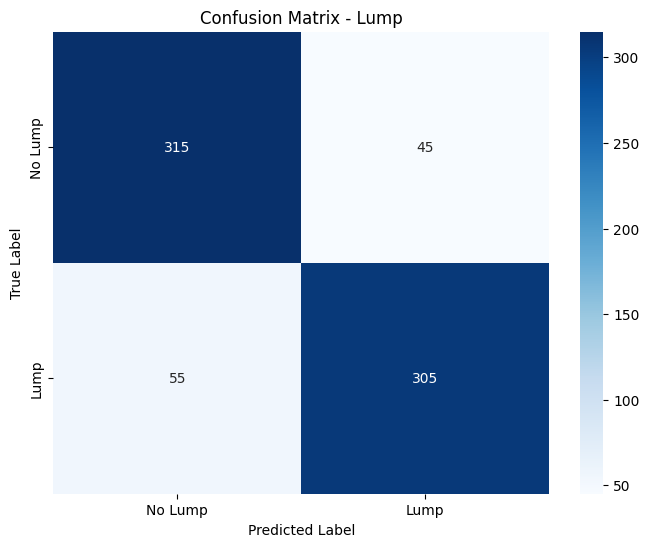


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.85      0.88      0.86       360
        Lump       0.87      0.85      0.86       360

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720


Confusion Matrix - Size:
[[ 88  14   6  12]
 [ 17  73  11  19]
 [  6  20  72  22]
 [  7  11  17 325]]


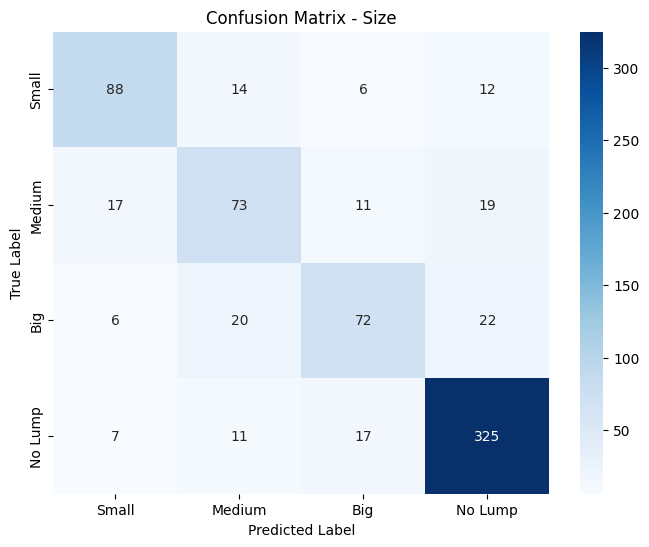


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.75      0.73      0.74       120
      Medium       0.62      0.61      0.61       120
         Big       0.68      0.60      0.64       120
     No Lump       0.86      0.90      0.88       360

    accuracy                           0.78       720
   macro avg       0.73      0.71      0.72       720
weighted avg       0.77      0.78      0.77       720


Confusion Matrix - Position:
[[ 68  22  11  19]
 [ 18  64  14  24]
 [ 23  31  46  20]
 [  5  16   7 332]]


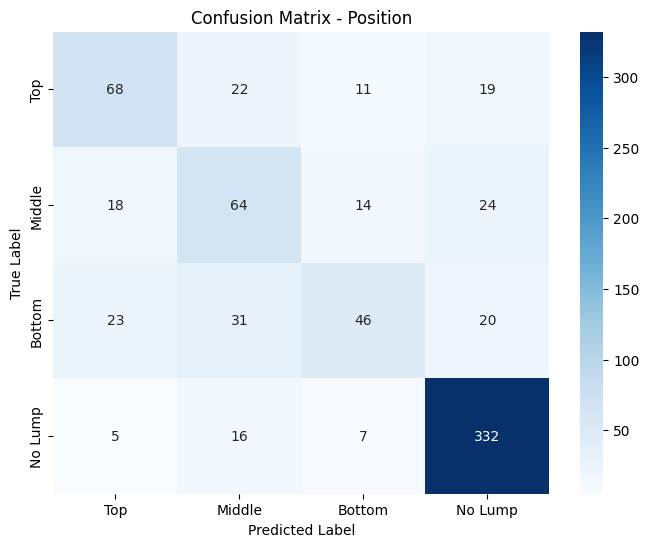


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.60      0.57      0.58       120
      Middle       0.48      0.53      0.51       120
      Bottom       0.59      0.38      0.46       120
     No Lump       0.84      0.92      0.88       360

    accuracy                           0.71       720
   macro avg       0.63      0.60      0.61       720
weighted avg       0.70      0.71      0.70       720


Testing on doctors' data without fine-tuning:


Test F1 (macro) - Lump: 0.3333, Size: 0.1594, Position: 0.0716

Confusion Matrix - Lump:
[[  0 144]
 [  0 144]]


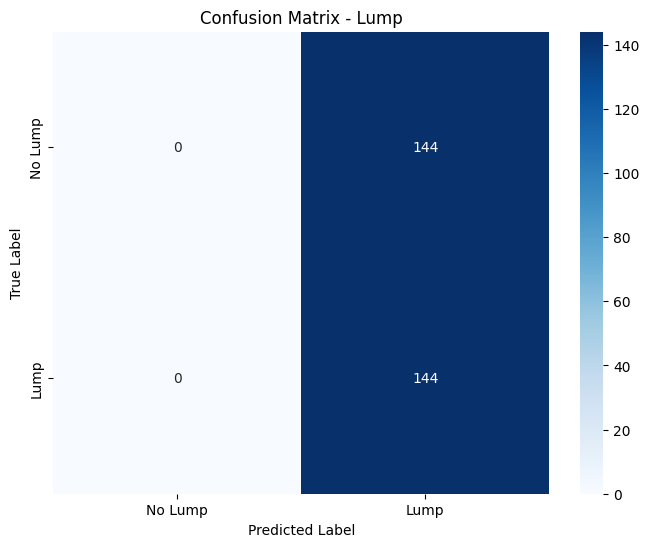


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.00      0.00      0.00       144
        Lump       0.50      1.00      0.67       144

    accuracy                           0.50       288
   macro avg       0.25      0.50      0.33       288
weighted avg       0.25      0.50      0.33       288


Confusion Matrix - Size:
[[  6   7  35   0]
 [  6  14  27   1]
 [  7  16  25   0]
 [ 13  11 120   0]]


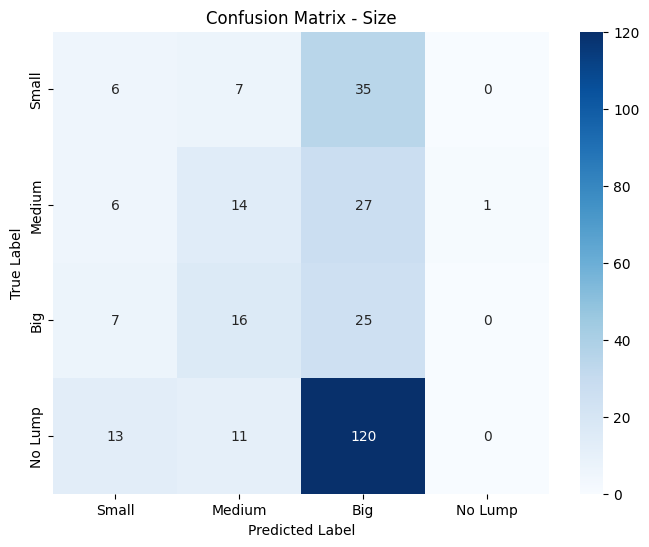


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.19      0.12      0.15        48
      Medium       0.29      0.29      0.29        48
         Big       0.12      0.52      0.20        48
     No Lump       0.00      0.00      0.00       144

    accuracy                           0.16       288
   macro avg       0.15      0.23      0.16       288
weighted avg       0.10      0.16      0.11       288


Confusion Matrix - Position:
[[  0   0  48   0]
 [  1   0  47   0]
 [  0   0  48   0]
 [  0   0 144   0]]


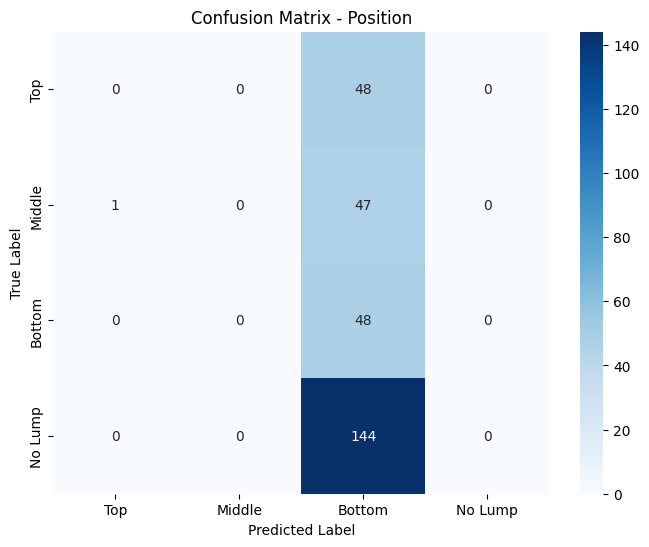


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.00      0.00      0.00        48
      Middle       0.00      0.00      0.00        48
      Bottom       0.17      1.00      0.29        48
     No Lump       0.00      0.00      0.00       144

    accuracy                           0.17       288
   macro avg       0.04      0.25      0.07       288
weighted avg       0.03      0.17      0.05       288


Fine-tuning with 1 additional trials from new dataset


Epoch 1, Training Loss: 1.2517, Validation Loss: 1.5717


Epoch 2, Training Loss: 1.1848, Validation Loss: 1.5072


Epoch 3, Training Loss: 1.1373, Validation Loss: 1.7161


Epoch 4, Training Loss: 1.2243, Validation Loss: 1.5240


Epoch 5, Training Loss: 1.0775, Validation Loss: 1.6747


Epoch 6, Training Loss: 1.1309, Validation Loss: 1.5616


Epoch 7, Training Loss: 1.0526, Validation Loss: 1.5649
Early stopping at epoch 7
Training Time: 14.65 seconds


Test F1 (macro) - Lump: 0.7714, Size: 0.3930, Position: 0.3603

Confusion Matrix - Lump:
[[ 88  56]
 [  8 136]]


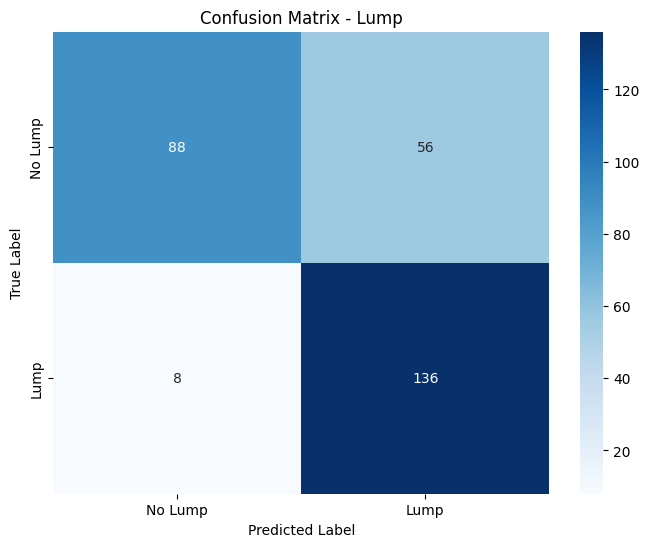


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.92      0.61      0.73       144
        Lump       0.71      0.94      0.81       144

    accuracy                           0.78       288
   macro avg       0.81      0.78      0.77       288
weighted avg       0.81      0.78      0.77       288


Confusion Matrix - Size:
[[24 18  2  4]
 [14 26  4  4]
 [15 17  2 14]
 [14 13 31 86]]


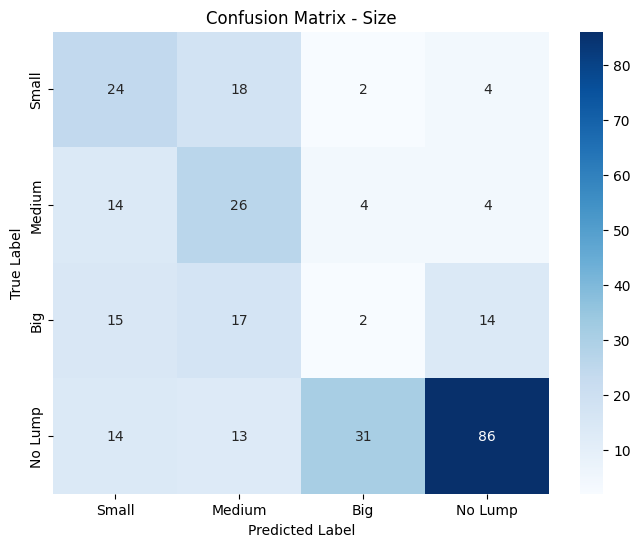


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.36      0.50      0.42        48
      Medium       0.35      0.54      0.43        48
         Big       0.05      0.04      0.05        48
     No Lump       0.80      0.60      0.68       144

    accuracy                           0.48       288
   macro avg       0.39      0.42      0.39       288
weighted avg       0.52      0.48      0.49       288


Confusion Matrix - Position:
[[ 2 14 32  0]
 [ 3 28 14  3]
 [ 2 16 23  7]
 [ 0 48 19 77]]


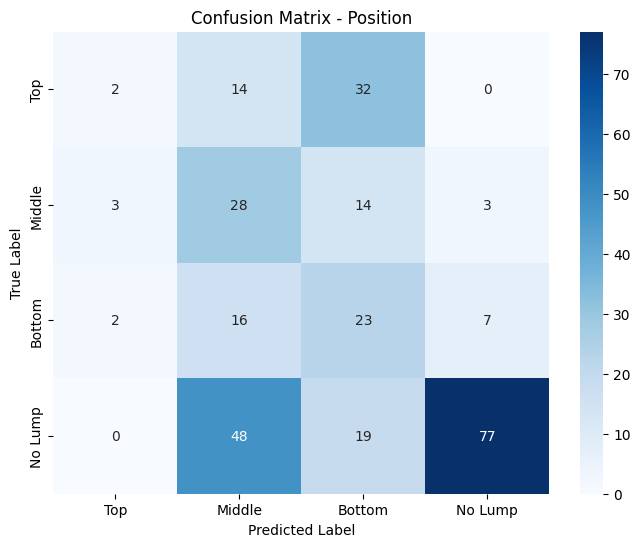


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.29      0.04      0.07        48
      Middle       0.26      0.58      0.36        48
      Bottom       0.26      0.48      0.34        48
     No Lump       0.89      0.53      0.67       144

    accuracy                           0.45       288
   macro avg       0.42      0.41      0.36       288
weighted avg       0.58      0.45      0.46       288


Fine-tuning with 2 additional trials from new dataset


Epoch 1, Training Loss: 1.1120, Validation Loss: 1.5168


Epoch 2, Training Loss: 1.0541, Validation Loss: 1.5655


Epoch 3, Training Loss: 1.0342, Validation Loss: 1.5216


Epoch 4, Training Loss: 1.0557, Validation Loss: 1.5339


Epoch 5, Training Loss: 1.0334, Validation Loss: 1.5674
Early stopping at epoch 5
Training Time: 10.52 seconds


Test F1 (macro) - Lump: 0.8402, Size: 0.4102, Position: 0.3595

Confusion Matrix - Lump:
[[125  19]
 [ 27 117]]


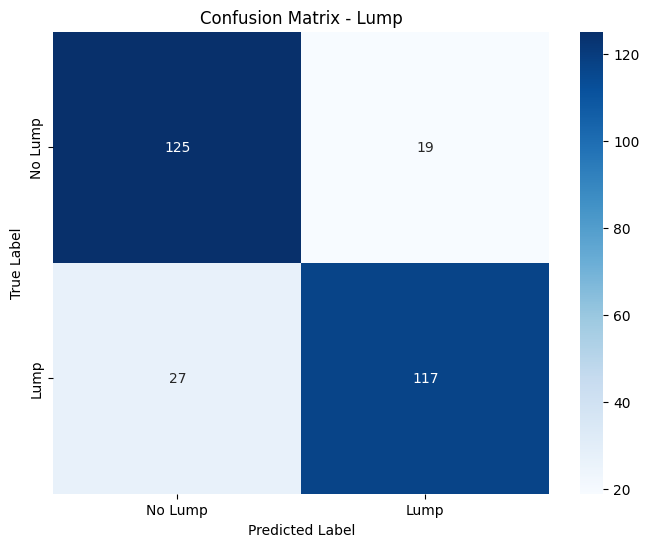


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.82      0.87      0.84       144
        Lump       0.86      0.81      0.84       144

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.84      0.84      0.84       288


Confusion Matrix - Size:
[[ 26  10   0  12]
 [ 22  16   0  10]
 [ 10  17   1  20]
 [ 12   3   0 129]]


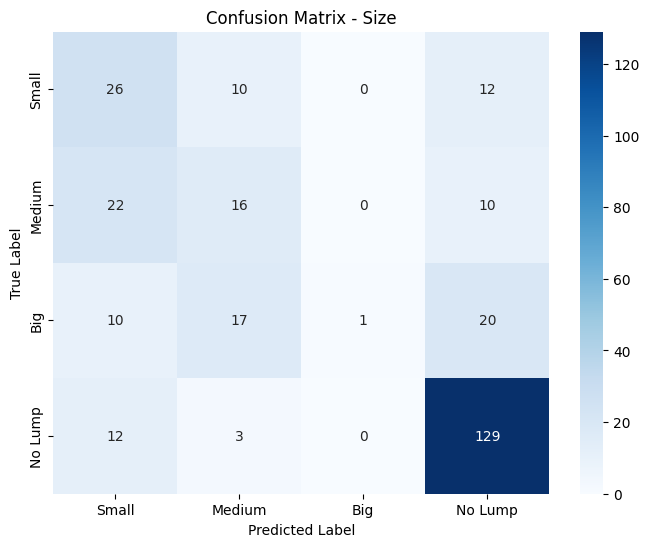


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.37      0.54      0.44        48
      Medium       0.35      0.33      0.34        48
         Big       1.00      0.02      0.04        48
     No Lump       0.75      0.90      0.82       144

    accuracy                           0.60       288
   macro avg       0.62      0.45      0.41       288
weighted avg       0.66      0.60      0.55       288


Confusion Matrix - Position:
[[  3  37   3   5]
 [  3  32   0  13]
 [  5  21   3  19]
 [  1  12   7 124]]


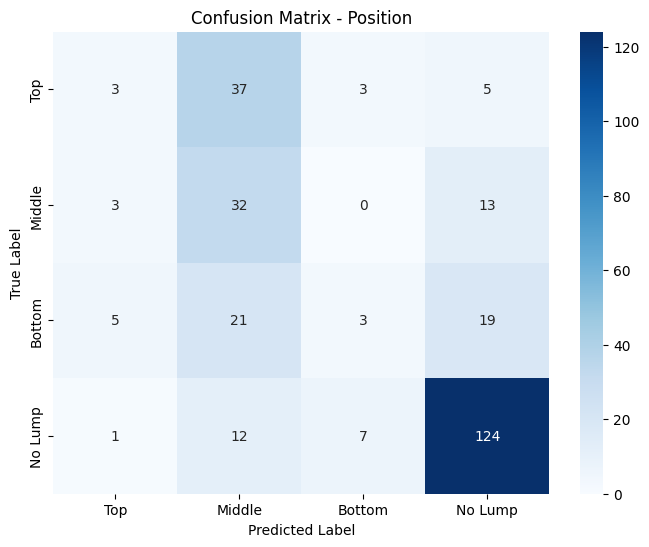


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.25      0.06      0.10        48
      Middle       0.31      0.67      0.43        48
      Bottom       0.23      0.06      0.10        48
     No Lump       0.77      0.86      0.81       144

    accuracy                           0.56       288
   macro avg       0.39      0.41      0.36       288
weighted avg       0.52      0.56      0.51       288


Fine-tuning with 3 additional trials from new dataset


Epoch 1, Training Loss: 0.9836, Validation Loss: 1.5993


Epoch 2, Training Loss: 1.0027, Validation Loss: 1.6341


Epoch 3, Training Loss: 0.9656, Validation Loss: 1.5588


Epoch 4, Training Loss: 0.9161, Validation Loss: 1.5888


Epoch 5, Training Loss: 0.9819, Validation Loss: 1.5744
Early stopping at epoch 5
Training Time: 10.64 seconds


Test F1 (macro) - Lump: 0.3561, Size: 0.2229, Position: 0.1634

Confusion Matrix - Lump:
[[  3 141]
 [  0 144]]


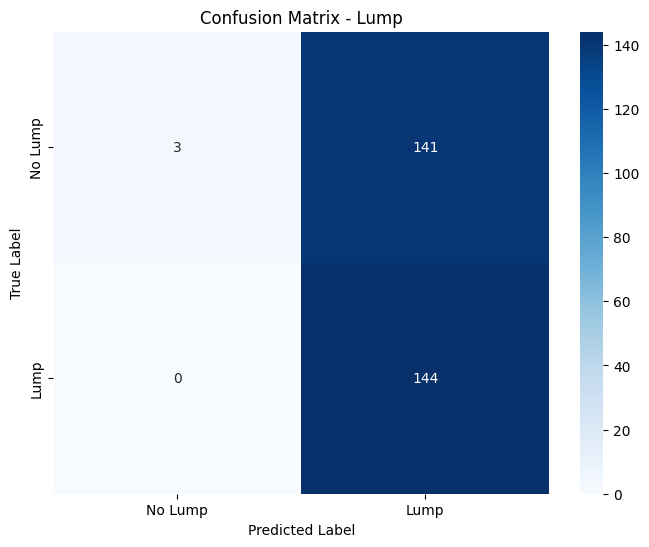


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       1.00      0.02      0.04       144
        Lump       0.51      1.00      0.67       144

    accuracy                           0.51       288
   macro avg       0.75      0.51      0.36       288
weighted avg       0.75      0.51      0.36       288


Confusion Matrix - Size:
[[ 28   4  16   0]
 [ 23   6  19   0]
 [ 17   1  30   0]
 [ 12   4 127   1]]


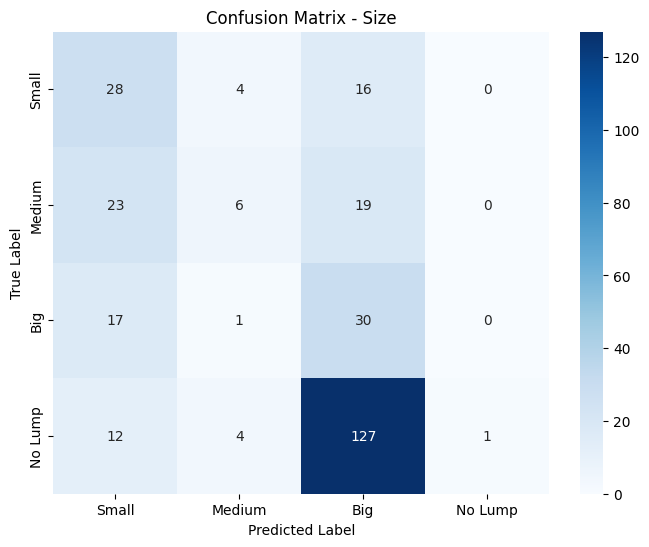


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.35      0.58      0.44        48
      Medium       0.40      0.12      0.19        48
         Big       0.16      0.62      0.25        48
     No Lump       1.00      0.01      0.01       144

    accuracy                           0.23       288
   macro avg       0.48      0.34      0.22       288
weighted avg       0.65      0.23      0.15       288


Confusion Matrix - Position:
[[  9  37   2   0]
 [  8  37   3   0]
 [  8  39   1   0]
 [ 13 114   6  11]]


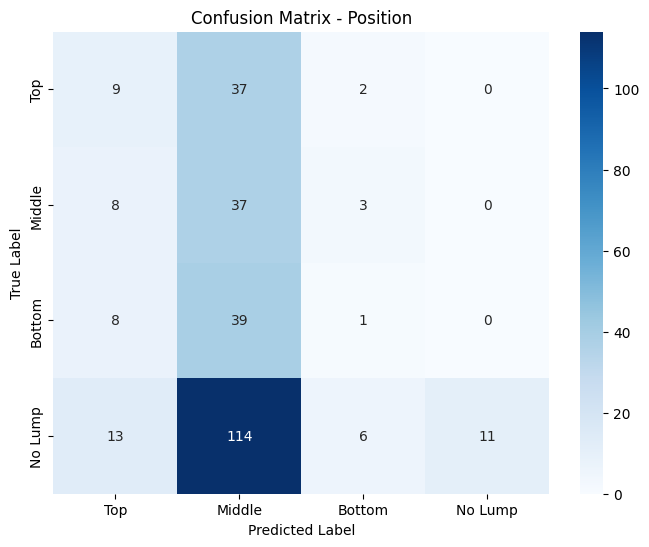


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.24      0.19      0.21        48
      Middle       0.16      0.77      0.27        48
      Bottom       0.08      0.02      0.03        48
     No Lump       1.00      0.08      0.14       144

    accuracy                           0.20       288
   macro avg       0.37      0.26      0.16       288
weighted avg       0.58      0.20      0.16       288


Fine-tuning with 4 additional trials from new dataset


Epoch 1, Training Loss: 0.9053, Validation Loss: 1.5569


Epoch 2, Training Loss: 0.9097, Validation Loss: 1.4824


Epoch 3, Training Loss: 0.9046, Validation Loss: 1.6361


Epoch 4, Training Loss: 0.8425, Validation Loss: 1.7972


Epoch 5, Training Loss: 0.8432, Validation Loss: 1.5932


Epoch 6, Training Loss: 0.8874, Validation Loss: 1.5994


Epoch 7, Training Loss: 1.0001, Validation Loss: 1.4755


Epoch 8, Training Loss: 0.8837, Validation Loss: 1.5732


Epoch 9, Training Loss: 0.8431, Validation Loss: 1.5167


Epoch 10, Training Loss: 0.9255, Validation Loss: 1.5804


Epoch 11, Training Loss: 0.8343, Validation Loss: 1.5503


Epoch 12, Training Loss: 0.8024, Validation Loss: 1.5322
Early stopping at epoch 12
Training Time: 27.22 seconds


Test F1 (macro) - Lump: 0.9097, Size: 0.5490, Position: 0.4675

Confusion Matrix - Lump:
[[130  14]
 [ 12 132]]


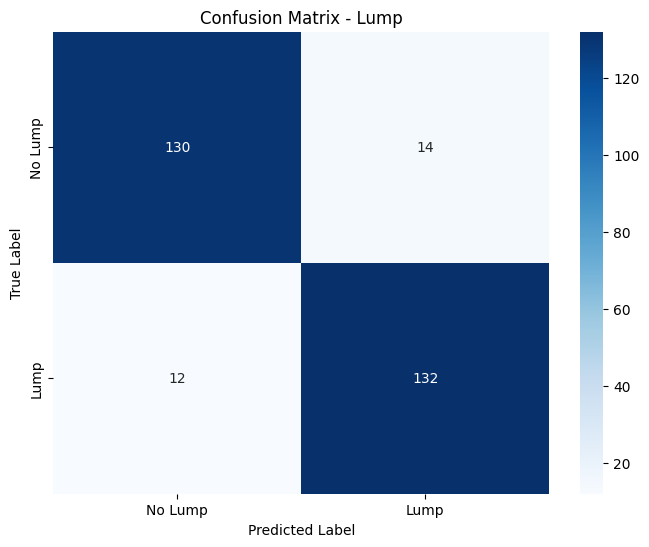


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.92      0.90      0.91       144
        Lump       0.90      0.92      0.91       144

    accuracy                           0.91       288
   macro avg       0.91      0.91      0.91       288
weighted avg       0.91      0.91      0.91       288


Confusion Matrix - Size:
[[ 10  12  26   0]
 [  2  20  26   0]
 [  0   4  34  10]
 [  0   1  11 132]]


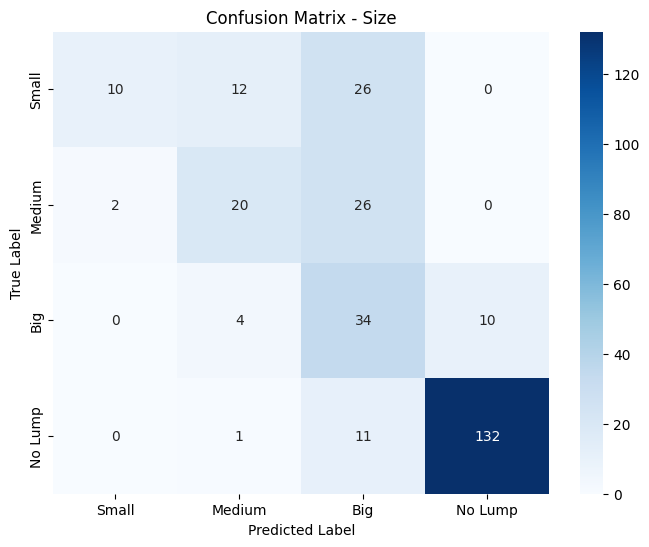


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.83      0.21      0.33        48
      Medium       0.54      0.42      0.47        48
         Big       0.35      0.71      0.47        48
     No Lump       0.93      0.92      0.92       144

    accuracy                           0.68       288
   macro avg       0.66      0.56      0.55       288
weighted avg       0.75      0.68      0.67       288


Confusion Matrix - Position:
[[  6  18  24   0]
 [  3  15  28   2]
 [  2   8  29   9]
 [  1   2   9 132]]


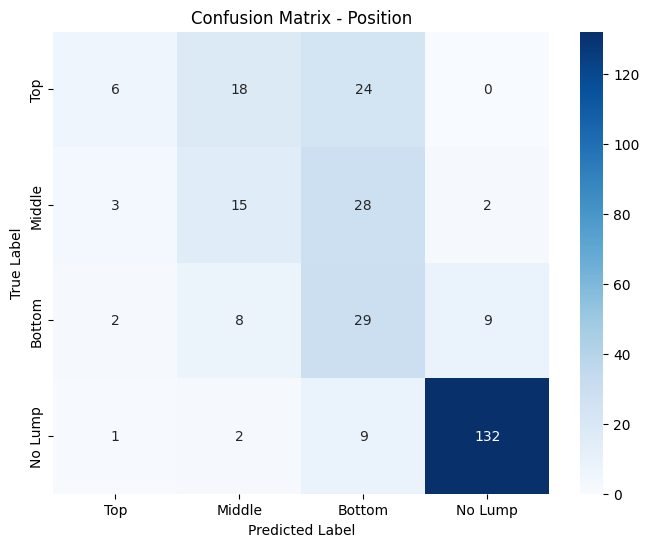


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.50      0.12      0.20        48
      Middle       0.35      0.31      0.33        48
      Bottom       0.32      0.60      0.42        48
     No Lump       0.92      0.92      0.92       144

    accuracy                           0.63       288
   macro avg       0.52      0.49      0.47       288
weighted avg       0.66      0.63      0.62       288


Fine-tuning with 5 additional trials from new dataset


Epoch 1, Training Loss: 0.8225, Validation Loss: 1.5650


Epoch 2, Training Loss: 0.7296, Validation Loss: 1.4965


Epoch 3, Training Loss: 0.7217, Validation Loss: 1.6388


Epoch 4, Training Loss: 0.7681, Validation Loss: 1.4847


Epoch 5, Training Loss: 0.6606, Validation Loss: 1.5665
Early stopping at epoch 5
Training Time: 11.58 seconds


Test F1 (macro) - Lump: 0.9236, Size: 0.5520, Position: 0.5314

Confusion Matrix - Lump:
[[132  12]
 [ 10 134]]


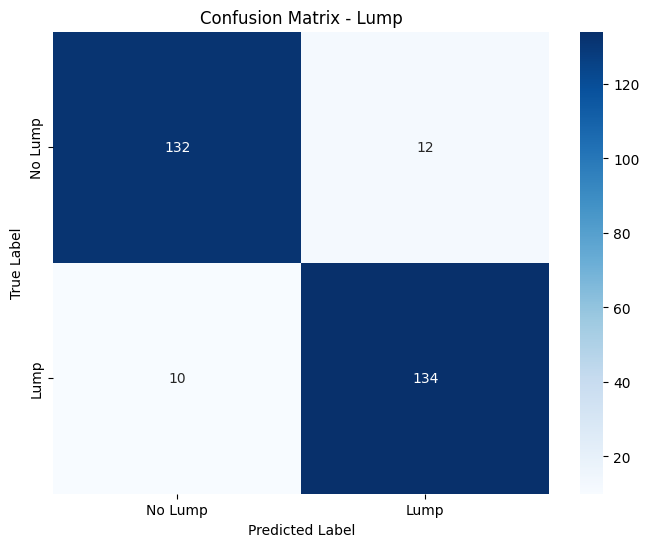


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.93      0.92      0.92       144
        Lump       0.92      0.93      0.92       144

    accuracy                           0.92       288
   macro avg       0.92      0.92      0.92       288
weighted avg       0.92      0.92      0.92       288


Confusion Matrix - Size:
[[ 45   1   1   1]
 [ 34   6   7   1]
 [ 15   3  19  11]
 [  5   1   5 133]]


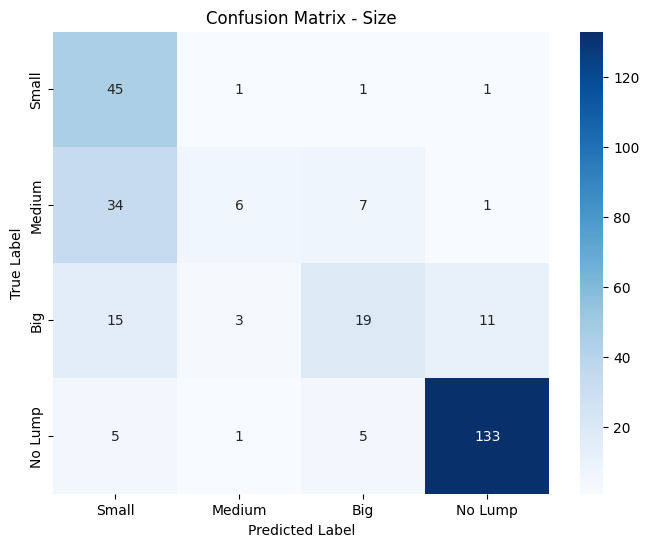


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.45      0.94      0.61        48
      Medium       0.55      0.12      0.20        48
         Big       0.59      0.40      0.47        48
     No Lump       0.91      0.92      0.92       144

    accuracy                           0.70       288
   macro avg       0.63      0.60      0.55       288
weighted avg       0.72      0.70      0.67       288


Confusion Matrix - Position:
[[ 13  15  20   0]
 [  4  17  23   4]
 [  6   6  30   6]
 [  0   3  10 131]]


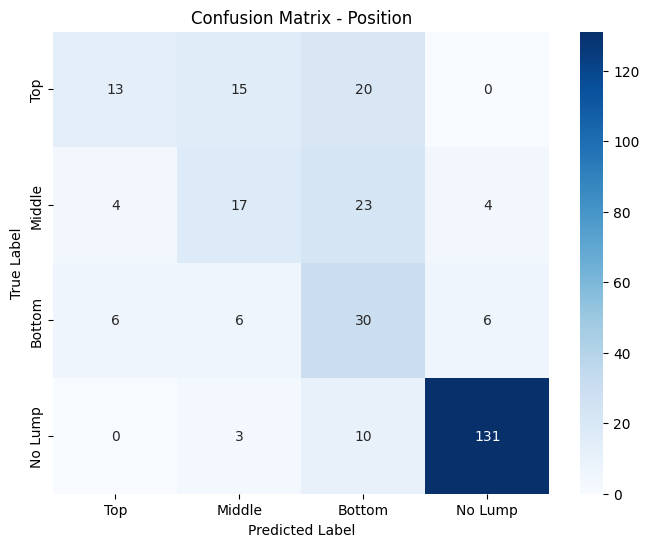


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.57      0.27      0.37        48
      Middle       0.41      0.35      0.38        48
      Bottom       0.36      0.62      0.46        48
     No Lump       0.93      0.91      0.92       144

    accuracy                           0.66       288
   macro avg       0.57      0.54      0.53       288
weighted avg       0.69      0.66      0.66       288


Fine-tuning with 6 additional trials from new dataset


Epoch 1, Training Loss: 0.6432, Validation Loss: 1.7406


Epoch 2, Training Loss: 0.6833, Validation Loss: 1.5961


Epoch 3, Training Loss: 0.7374, Validation Loss: 1.7654


Epoch 4, Training Loss: 0.7080, Validation Loss: 1.6376


Epoch 5, Training Loss: 0.6754, Validation Loss: 1.6859
Early stopping at epoch 5
Training Time: 11.29 seconds


Test F1 (macro) - Lump: 0.8028, Size: 0.6380, Position: 0.5470

Confusion Matrix - Lump:
[[ 91  53]
 [  2 142]]


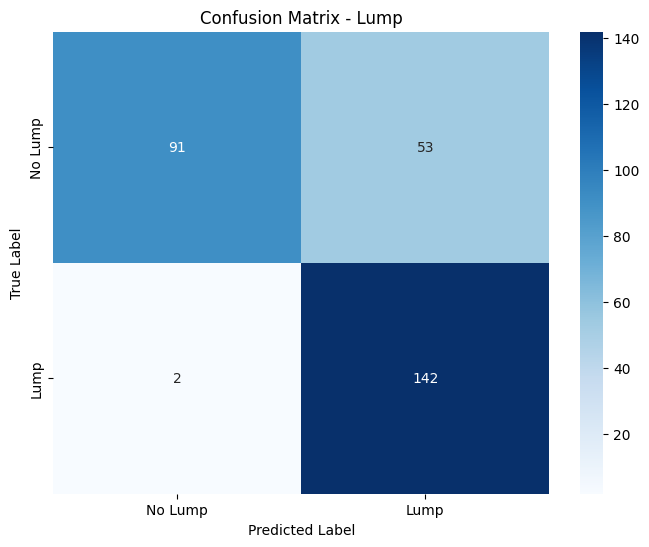


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.98      0.63      0.77       144
        Lump       0.73      0.99      0.84       144

    accuracy                           0.81       288
   macro avg       0.85      0.81      0.80       288
weighted avg       0.85      0.81      0.80       288


Confusion Matrix - Size:
[[ 30  15   3   0]
 [ 13  34   1   0]
 [  3  14  27   4]
 [  0  15  22 107]]


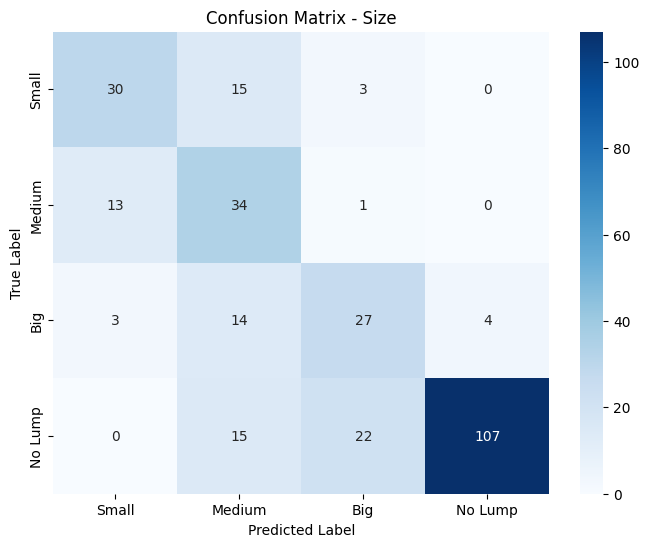


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.65      0.62      0.64        48
      Medium       0.44      0.71      0.54        48
         Big       0.51      0.56      0.53        48
     No Lump       0.96      0.74      0.84       144

    accuracy                           0.69       288
   macro avg       0.64      0.66      0.64       288
weighted avg       0.75      0.69      0.71       288


Confusion Matrix - Position:
[[ 40   3   5   0]
 [ 24  14  10   0]
 [ 22   1  23   2]
 [  9   5  27 103]]


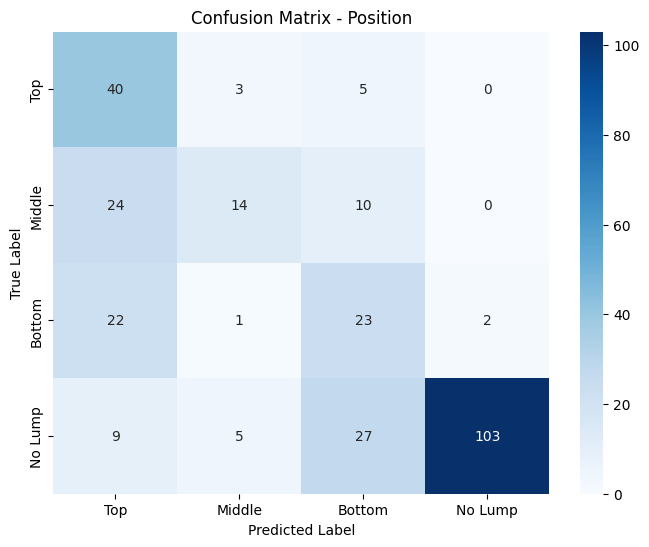


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.42      0.83      0.56        48
      Middle       0.61      0.29      0.39        48
      Bottom       0.35      0.48      0.41        48
     No Lump       0.98      0.72      0.83       144

    accuracy                           0.62       288
   macro avg       0.59      0.58      0.55       288
weighted avg       0.72      0.62      0.64       288


Fine-tuning with 7 additional trials from new dataset


Epoch 1, Training Loss: 0.6427, Validation Loss: 1.5770


Epoch 2, Training Loss: 0.6428, Validation Loss: 1.7592


Epoch 3, Training Loss: 0.6654, Validation Loss: 1.7944


Epoch 4, Training Loss: 0.6322, Validation Loss: 1.7126


Epoch 5, Training Loss: 0.6428, Validation Loss: 1.5000
Early stopping at epoch 5
Training Time: 10.86 seconds


Test F1 (macro) - Lump: 0.9167, Size: 0.7446, Position: 0.5492

Confusion Matrix - Lump:
[[132  12]
 [ 12 132]]


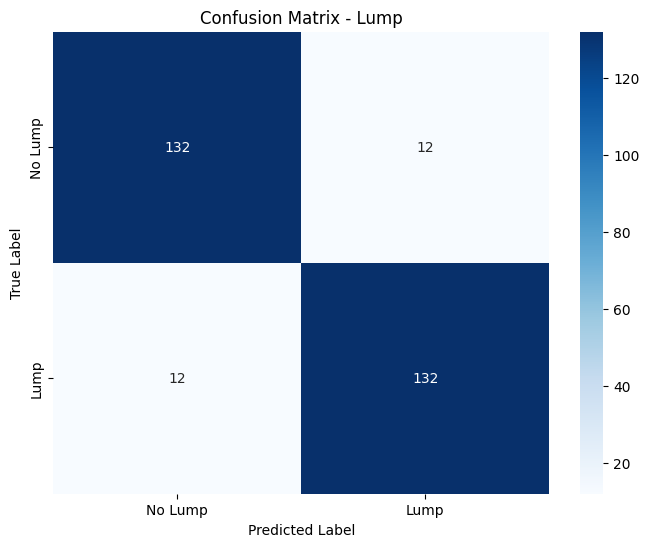


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.92      0.92      0.92       144
        Lump       0.92      0.92      0.92       144

    accuracy                           0.92       288
   macro avg       0.92      0.92      0.92       288
weighted avg       0.92      0.92      0.92       288


Confusion Matrix - Size:
[[ 39   5   4   0]
 [ 13  33   2   0]
 [  6   4  26  12]
 [  1   3   5 135]]


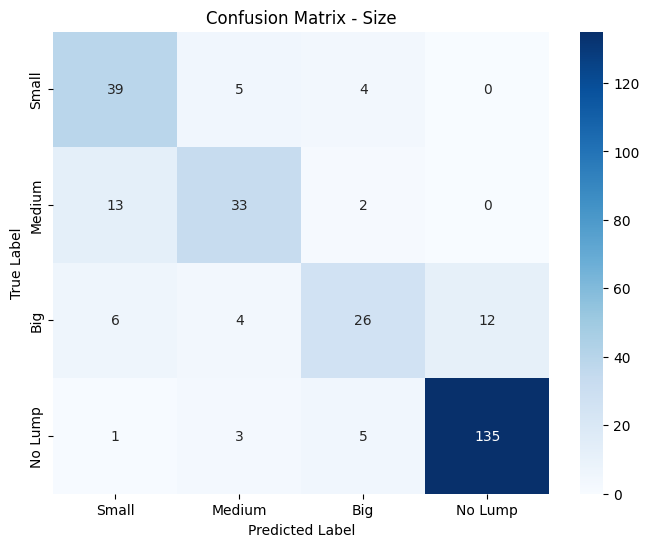


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.66      0.81      0.73        48
      Medium       0.73      0.69      0.71        48
         Big       0.70      0.54      0.61        48
     No Lump       0.92      0.94      0.93       144

    accuracy                           0.81       288
   macro avg       0.75      0.74      0.74       288
weighted avg       0.81      0.81      0.81       288


Confusion Matrix - Position:
[[ 12  26  10   0]
 [  4  30   9   5]
 [  4  13  21  10]
 [  0   8   4 132]]


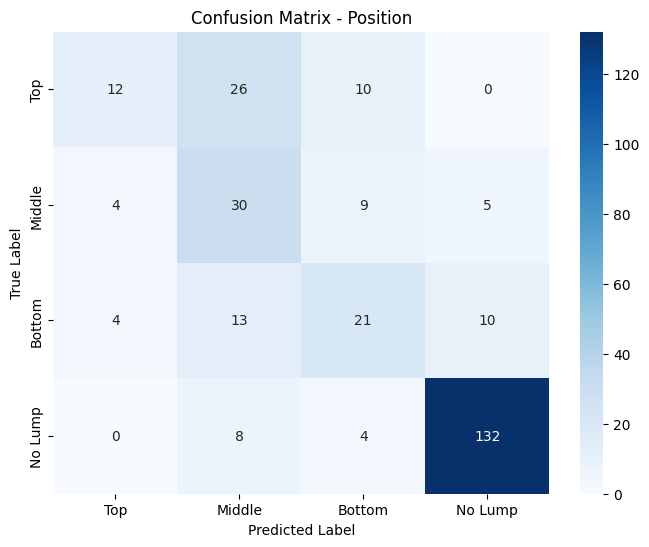


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.60      0.25      0.35        48
      Middle       0.39      0.62      0.48        48
      Bottom       0.48      0.44      0.46        48
     No Lump       0.90      0.92      0.91       144

    accuracy                           0.68       288
   macro avg       0.59      0.56      0.55       288
weighted avg       0.69      0.68      0.67       288


Fine-tuning with 8 additional trials from new dataset


Epoch 1, Training Loss: 0.6208, Validation Loss: 1.7757


Epoch 2, Training Loss: 0.6661, Validation Loss: 1.6738


Epoch 3, Training Loss: 0.6261, Validation Loss: 1.6211


Epoch 4, Training Loss: 0.6639, Validation Loss: 1.6770


Epoch 5, Training Loss: 0.5442, Validation Loss: 1.6561
Early stopping at epoch 5
Training Time: 11.45 seconds


Test F1 (macro) - Lump: 0.8772, Size: 0.7212, Position: 0.6152

Confusion Matrix - Lump:
[[112  32]
 [  3 141]]


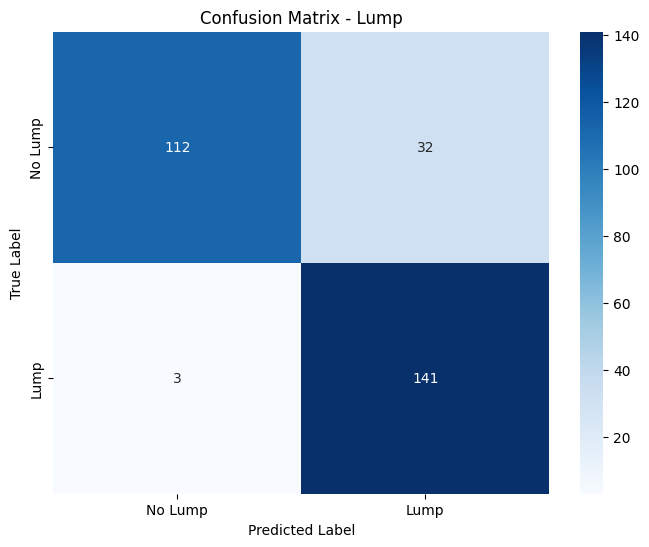


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.97      0.78      0.86       144
        Lump       0.82      0.98      0.89       144

    accuracy                           0.88       288
   macro avg       0.89      0.88      0.88       288
weighted avg       0.89      0.88      0.88       288


Confusion Matrix - Size:
[[ 32  15   1   0]
 [  4  43   1   0]
 [  1  15  29   3]
 [  1  15  13 115]]


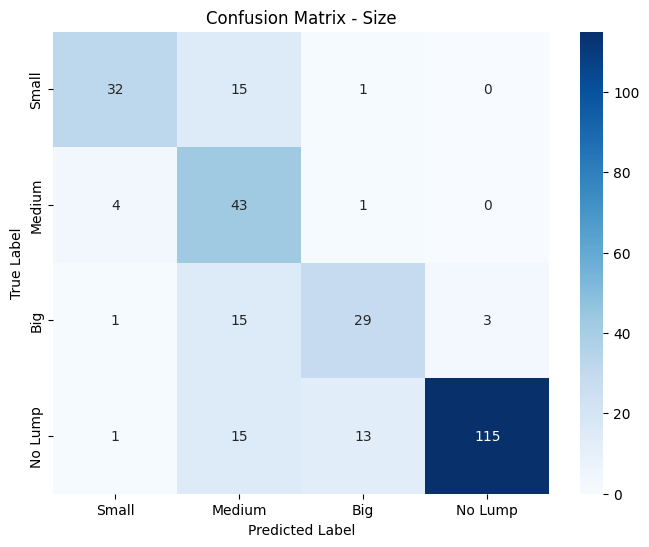


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.84      0.67      0.74        48
      Medium       0.49      0.90      0.63        48
         Big       0.66      0.60      0.63        48
     No Lump       0.97      0.80      0.88       144

    accuracy                           0.76       288
   macro avg       0.74      0.74      0.72       288
weighted avg       0.82      0.76      0.77       288


Confusion Matrix - Position:
[[ 31   7  10   0]
 [  6  30  12   0]
 [ 16   9  21   2]
 [  2   5  22 115]]


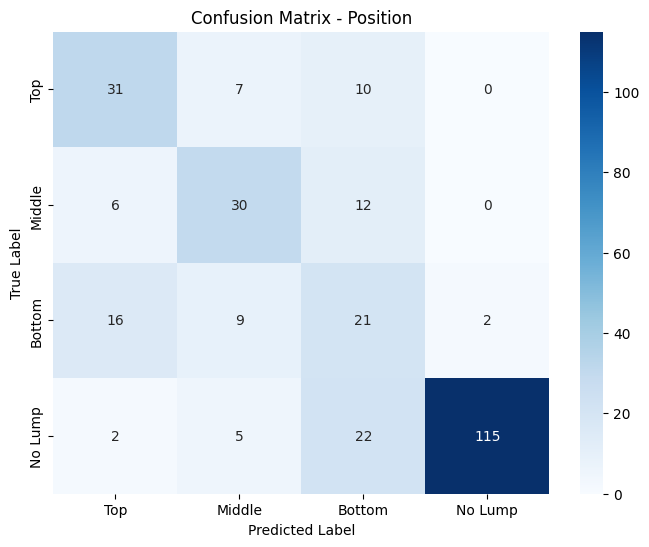


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.56      0.65      0.60        48
      Middle       0.59      0.62      0.61        48
      Bottom       0.32      0.44      0.37        48
     No Lump       0.98      0.80      0.88       144

    accuracy                           0.68       288
   macro avg       0.61      0.63      0.62       288
weighted avg       0.74      0.68      0.70       288


Fine-tuning with 9 additional trials from new dataset


Epoch 1, Training Loss: 0.5603, Validation Loss: 1.8850


Epoch 2, Training Loss: 0.7311, Validation Loss: 1.7217


Epoch 3, Training Loss: 0.6126, Validation Loss: 1.6832


Epoch 4, Training Loss: 0.6043, Validation Loss: 1.6843


Epoch 5, Training Loss: 0.5611, Validation Loss: 1.5206
Early stopping at epoch 5
Training Time: 10.88 seconds


Test F1 (macro) - Lump: 0.8297, Size: 0.7839, Position: 0.6355

Confusion Matrix - Lump:
[[ 99  45]
 [  3 141]]


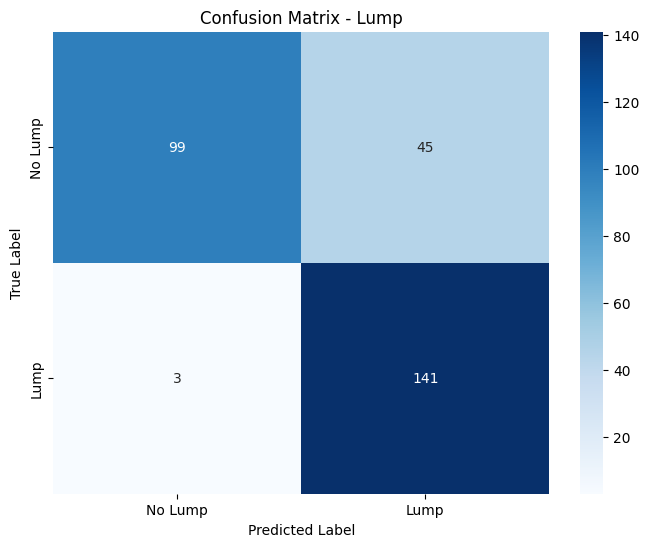


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.97      0.69      0.80       144
        Lump       0.76      0.98      0.85       144

    accuracy                           0.83       288
   macro avg       0.86      0.83      0.83       288
weighted avg       0.86      0.83      0.83       288


Confusion Matrix - Size:
[[ 37   8   3   0]
 [  3  42   3   0]
 [  2   3  40   3]
 [  3  11  17 113]]


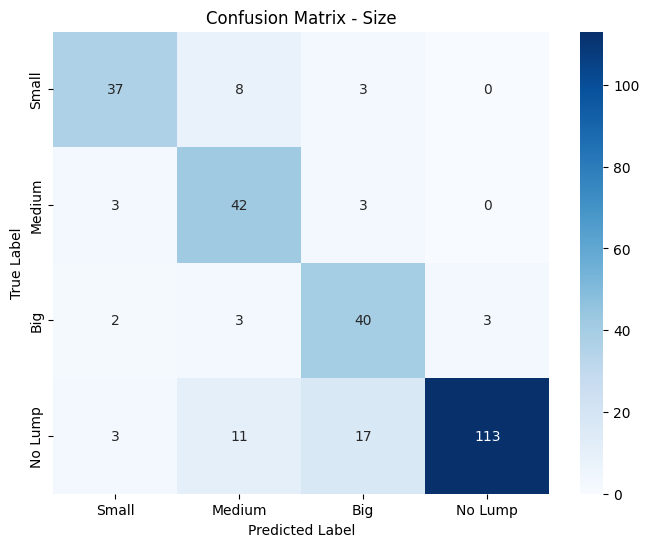


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.82      0.77      0.80        48
      Medium       0.66      0.88      0.75        48
         Big       0.63      0.83      0.72        48
     No Lump       0.97      0.78      0.87       144

    accuracy                           0.81       288
   macro avg       0.77      0.82      0.78       288
weighted avg       0.84      0.81      0.81       288


Confusion Matrix - Position:
[[ 34  11   3   0]
 [  6  35   5   2]
 [ 14  12  20   2]
 [  5   7  19 113]]


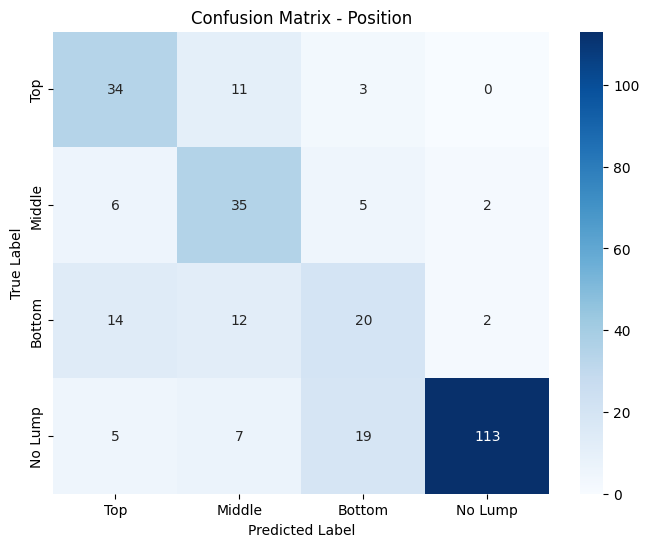


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.58      0.71      0.64        48
      Middle       0.54      0.73      0.62        48
      Bottom       0.43      0.42      0.42        48
     No Lump       0.97      0.78      0.87       144

    accuracy                           0.70       288
   macro avg       0.63      0.66      0.64       288
weighted avg       0.74      0.70      0.71       288


Fine-tuning with 10 additional trials from new dataset


Epoch 1, Training Loss: 0.6118, Validation Loss: 1.5523


Epoch 2, Training Loss: 0.5120, Validation Loss: 1.6429


Epoch 3, Training Loss: 0.5704, Validation Loss: 1.6382


Epoch 4, Training Loss: 0.5208, Validation Loss: 1.5744


Epoch 5, Training Loss: 0.5887, Validation Loss: 1.8947
Early stopping at epoch 5
Training Time: 10.85 seconds


Test F1 (macro) - Lump: 0.9166, Size: 0.7848, Position: 0.7304

Confusion Matrix - Lump:
[[128  16]
 [  8 136]]


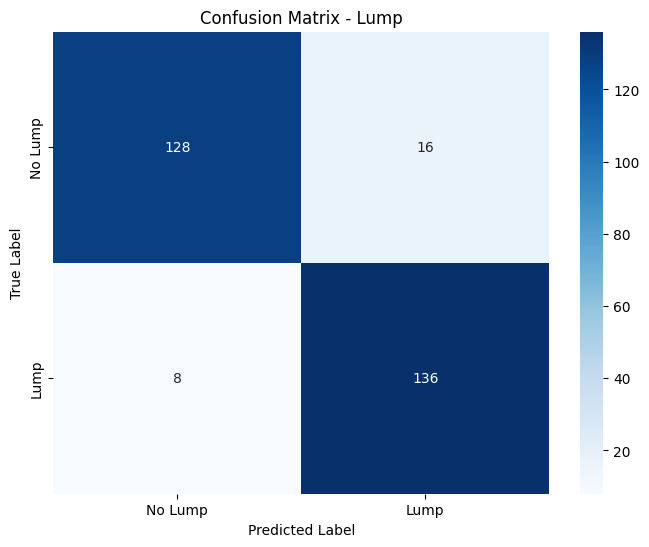


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.94      0.89      0.91       144
        Lump       0.89      0.94      0.92       144

    accuracy                           0.92       288
   macro avg       0.92      0.92      0.92       288
weighted avg       0.92      0.92      0.92       288


Confusion Matrix - Size:
[[ 38   7   3   0]
 [  4  44   0   0]
 [  1  11  29   7]
 [  3   5   9 127]]


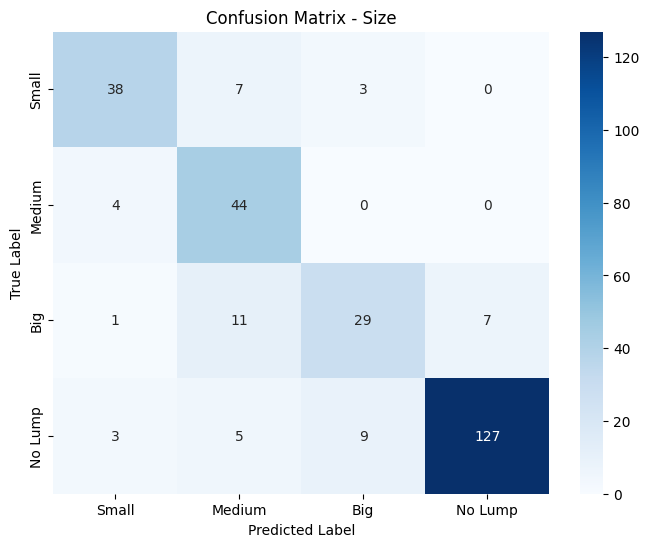


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.83      0.79      0.81        48
      Medium       0.66      0.92      0.77        48
         Big       0.71      0.60      0.65        48
     No Lump       0.95      0.88      0.91       144

    accuracy                           0.83       288
   macro avg       0.78      0.80      0.78       288
weighted avg       0.84      0.83      0.83       288


Confusion Matrix - Position:
[[ 38   3   7   0]
 [  9  31   6   2]
 [  8   5  28   7]
 [  0   5   7 132]]


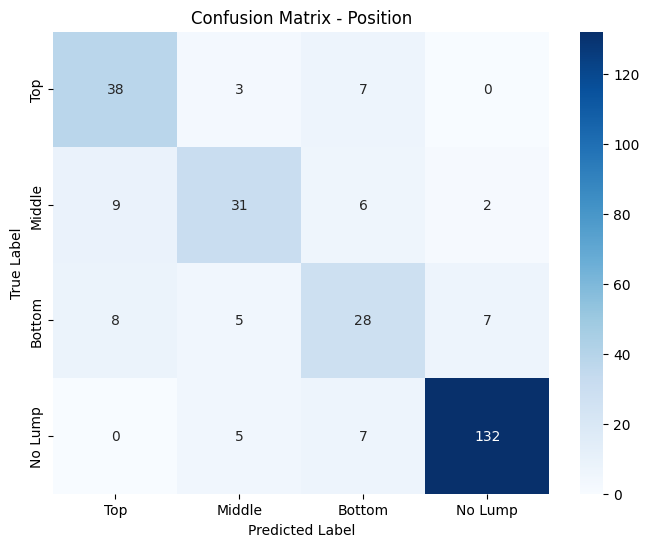


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.69      0.79      0.74        48
      Middle       0.70      0.65      0.67        48
      Bottom       0.58      0.58      0.58        48
     No Lump       0.94      0.92      0.93       144

    accuracy                           0.80       288
   macro avg       0.73      0.73      0.73       288
weighted avg       0.80      0.80      0.80       288


Fine-tuning with 11 additional trials from new dataset


Epoch 1, Training Loss: 0.5419, Validation Loss: 1.7108


Epoch 2, Training Loss: 0.5410, Validation Loss: 1.7280


Epoch 3, Training Loss: 0.5501, Validation Loss: 1.8793


Epoch 4, Training Loss: 0.5320, Validation Loss: 1.6606


Epoch 5, Training Loss: 0.4251, Validation Loss: 1.8716
Early stopping at epoch 5
Training Time: 10.77 seconds


Test F1 (macro) - Lump: 0.9198, Size: 0.8373, Position: 0.6196

Confusion Matrix - Lump:
[[123  21]
 [  2 142]]


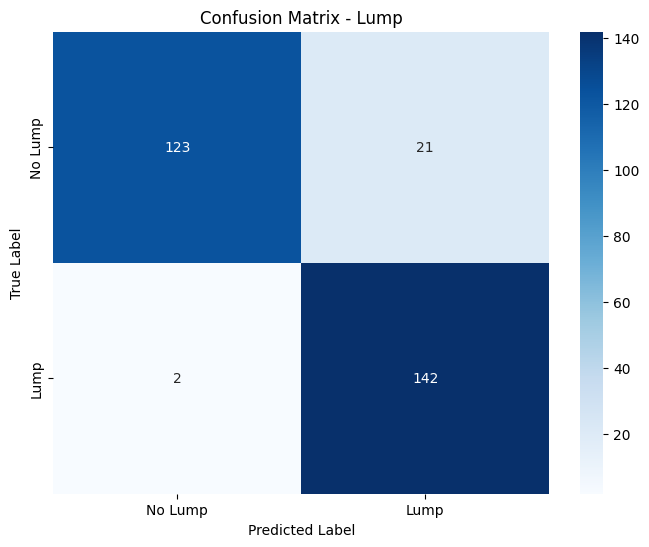


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.98      0.85      0.91       144
        Lump       0.87      0.99      0.93       144

    accuracy                           0.92       288
   macro avg       0.93      0.92      0.92       288
weighted avg       0.93      0.92      0.92       288


Confusion Matrix - Size:
[[ 41   3   3   1]
 [  5  41   2   0]
 [  0   5  42   1]
 [  1   2  18 123]]


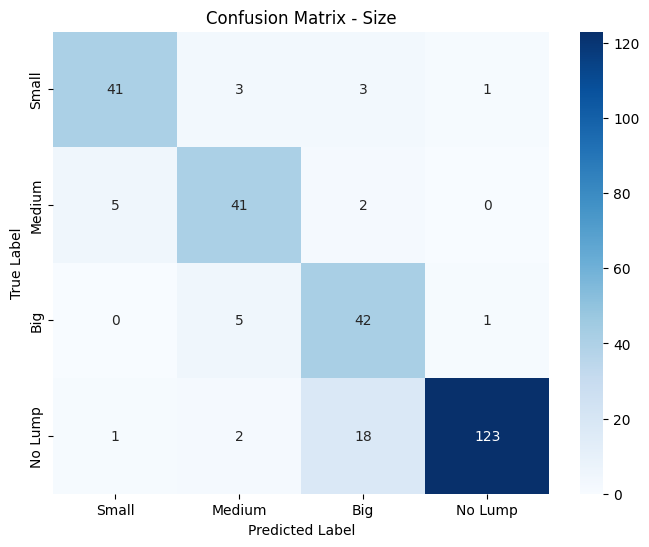


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.87      0.85      0.86        48
      Medium       0.80      0.85      0.83        48
         Big       0.65      0.88      0.74        48
     No Lump       0.98      0.85      0.91       144

    accuracy                           0.86       288
   macro avg       0.83      0.86      0.84       288
weighted avg       0.88      0.86      0.86       288


Confusion Matrix - Position:
[[ 30   0  18   0]
 [  3  12  32   1]
 [  3   1  44   0]
 [  0   2  30 112]]


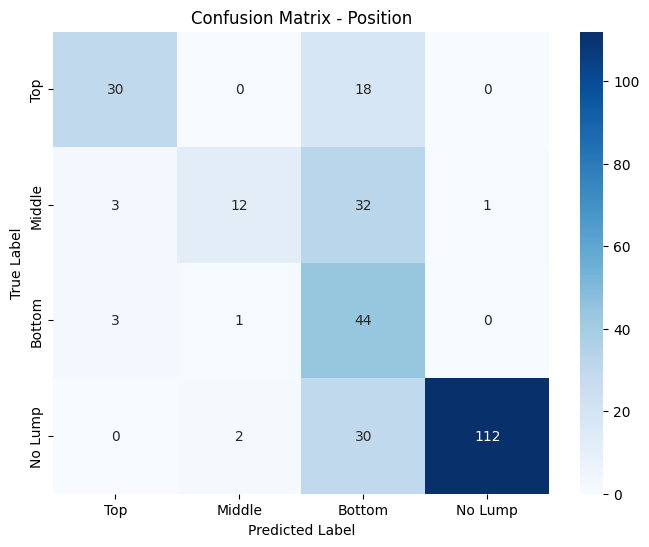


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.83      0.62      0.71        48
      Middle       0.80      0.25      0.38        48
      Bottom       0.35      0.92      0.51        48
     No Lump       0.99      0.78      0.87       144

    accuracy                           0.69       288
   macro avg       0.74      0.64      0.62       288
weighted avg       0.83      0.69      0.70       288


Fine-tuning with 12 additional trials from new dataset


Epoch 1, Training Loss: 0.5673, Validation Loss: 1.8627


Epoch 2, Training Loss: 0.5841, Validation Loss: 1.7928


Epoch 3, Training Loss: 0.4843, Validation Loss: 1.6283


Epoch 4, Training Loss: 0.5091, Validation Loss: 1.6934


Epoch 5, Training Loss: 0.4604, Validation Loss: 1.8543
Early stopping at epoch 5
Training Time: 11.27 seconds


Test F1 (macro) - Lump: 0.9375, Size: 0.8514, Position: 0.7641

Confusion Matrix - Lump:
[[133  11]
 [  7 137]]


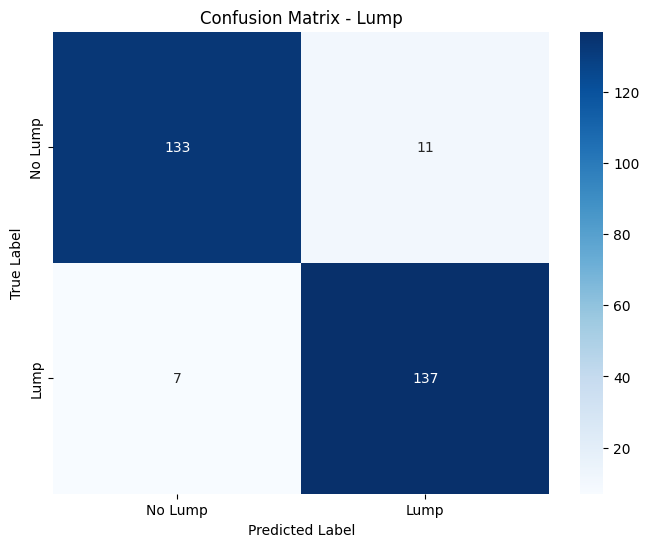


Classification Report - Lump:
              precision    recall  f1-score   support

     No Lump       0.95      0.92      0.94       144
        Lump       0.93      0.95      0.94       144

    accuracy                           0.94       288
   macro avg       0.94      0.94      0.94       288
weighted avg       0.94      0.94      0.94       288


Confusion Matrix - Size:
[[ 39   4   5   0]
 [  4  39   5   0]
 [  0   1  44   3]
 [  1   2  10 131]]


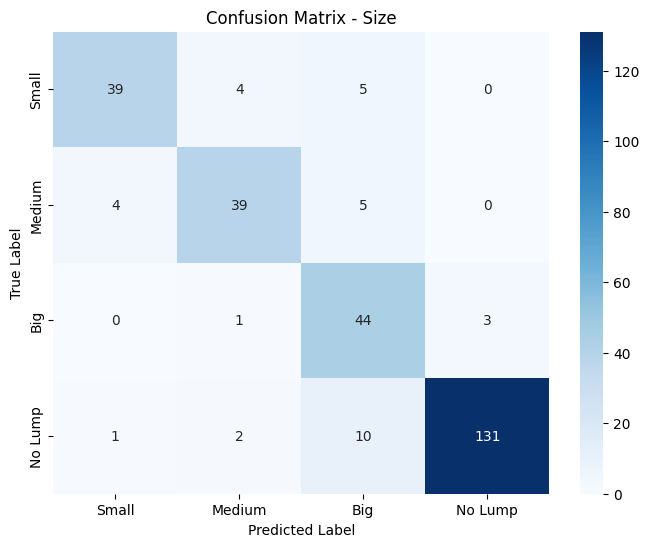


Classification Report - Size:
              precision    recall  f1-score   support

       Small       0.89      0.81      0.85        48
      Medium       0.85      0.81      0.83        48
         Big       0.69      0.92      0.79        48
     No Lump       0.98      0.91      0.94       144

    accuracy                           0.88       288
   macro avg       0.85      0.86      0.85       288
weighted avg       0.89      0.88      0.88       288


Confusion Matrix - Position:
[[ 37   6   5   0]
 [  4  40   2   2]
 [ 11   7  25   5]
 [  0   6   1 137]]


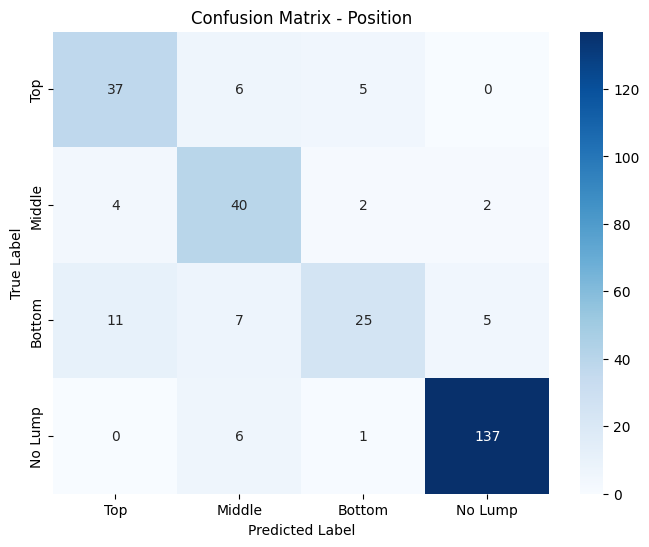


Classification Report - Position:
              precision    recall  f1-score   support

         Top       0.71      0.77      0.74        48
      Middle       0.68      0.83      0.75        48
      Bottom       0.76      0.52      0.62        48
     No Lump       0.95      0.95      0.95       144

    accuracy                           0.83       288
   macro avg       0.77      0.77      0.76       288
weighted avg       0.83      0.83      0.83       288

Few-shot early stopping at step 12


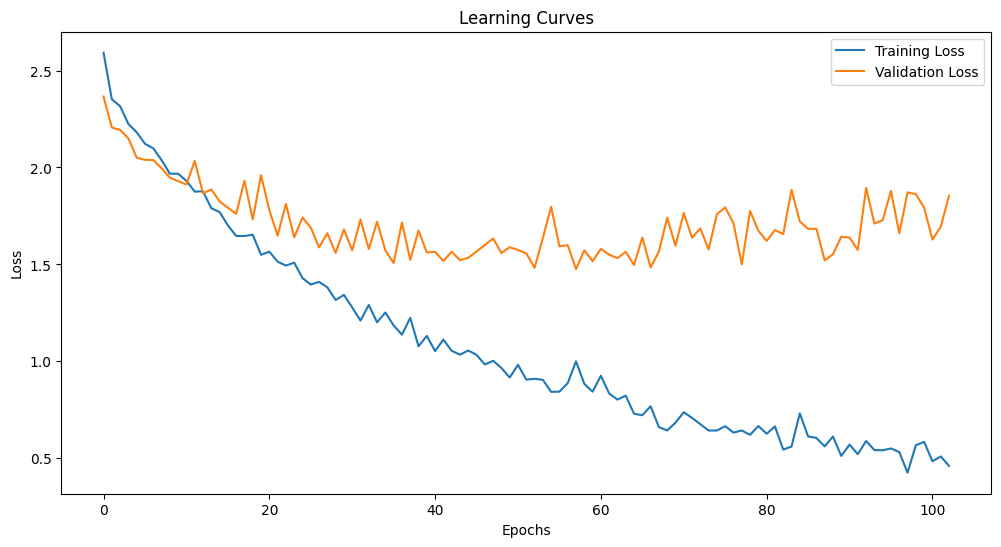

| Training Phase                         |   Lump F1 (macro) |   Size F1 (macro) |   Position F1 (macro) |   Training Time |
|:---------------------------------------|------------------:|------------------:|----------------------:|----------------:|
| Initial Training                       |          0.861084 |          0.717717 |             0.607811  |         72.7654 |
| Testing on doctors without fine-tuning |          0.333333 |          0.159436 |             0.0716418 |        nan      |
| Fine-tuning with 1 trials              |          0.771429 |          0.393034 |             0.360316  |         14.6462 |
| Fine-tuning with 2 trials              |          0.840154 |          0.410242 |             0.359536  |         10.5228 |
| Fine-tuning with 3 trials              |          0.356072 |          0.222942 |             0.163416  |         10.6379 |
| Fine-tuning with 4 trials              |          0.909718 |          0.548991 |             0.467455  |         27.2165 |


In [23]:
initial_accuracies, fine_tune_accuracies = train_multitask_model(sensor_indices, num_seconds, train_df, valid_df, test_df, additional_df=doctors_df, few_shot_steps=50)